In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [12]:
# Read the matching results csv file
df = pd.read_csv('data/mikenetopti.csv')
gt = pd.read_csv("data/gt_data.csv")

# rename the # basename column to basename
df.rename(columns={'# basename': 'basename'}, inplace=True)
gt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260 entries, 0 to 2259
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   basename  2260 non-null   int64
 1   x_gt      2260 non-null   int64
 2   y_gt      2260 non-null   int64
dtypes: int64(3)
memory usage: 53.1 KB


# Let's visualize the distribution of keypoints in the dataset
<p>We can clearly identify that the task of detecting pole bases is in the context of highly structured images.</p>

<AxesSubplot:xlabel='x_gt', ylabel='y_gt'>

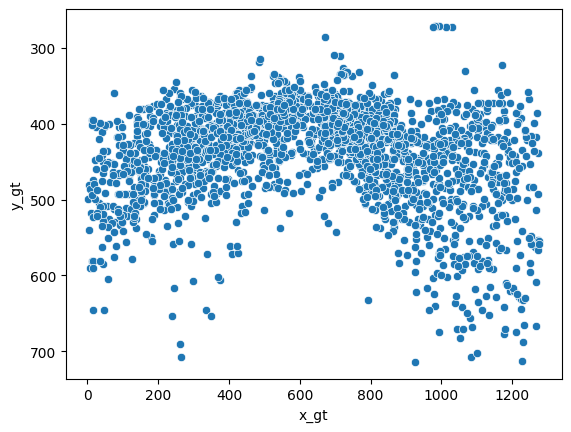

In [13]:
plt.gca().invert_yaxis()
sns.scatterplot(x='x_gt', y='y_gt', data=gt)

in_df
True     1756
False     504
Name: count, dtype: int64


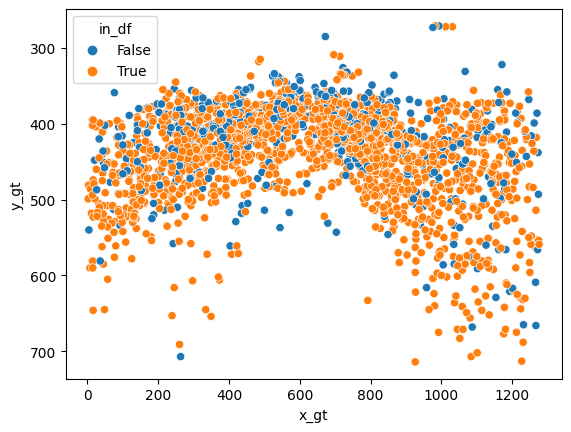

In [14]:
gt['in_df'] = gt.apply(lambda row: True if (row['x_gt'], row['y_gt']) in zip(df['x_gt'], df['y_gt']) else False, axis=1)
plt.gca().invert_yaxis()

sns.scatterplot(x='x_gt', y='y_gt', data=gt, hue='in_df')
print(gt['in_df'].value_counts())


<AxesSubplot:xlabel='x_gt', ylabel='y_gt'>

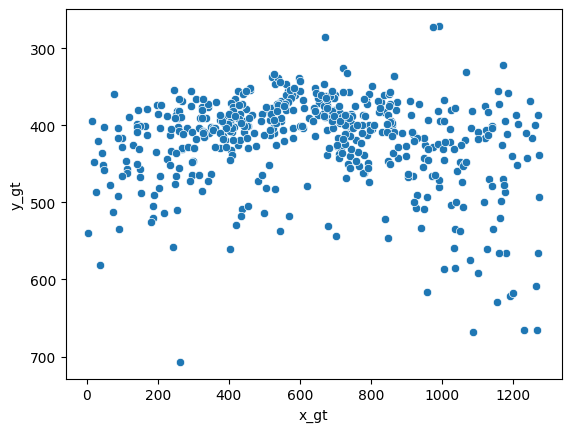

In [15]:
plt.gca().invert_yaxis()
sns.scatterplot(x='x_gt', y='y_gt', data=gt[gt.in_df==False])


## Let's dig into the errors of the predictions

In [16]:
df['l1_distance'] = df.apply(lambda row: abs(row['x_gt'] - row['x_pred']) + abs(row['y_gt'] - row['y_pred']), axis=1)
df['x_distance'] = df.apply(lambda row: abs(row['x_gt'] - row['x_pred']), axis=1)

Average height for no Depth Loss model
Predicted: 443.38547071905117
Missed! 440.9775


Text(0, 0.5, 'Count')

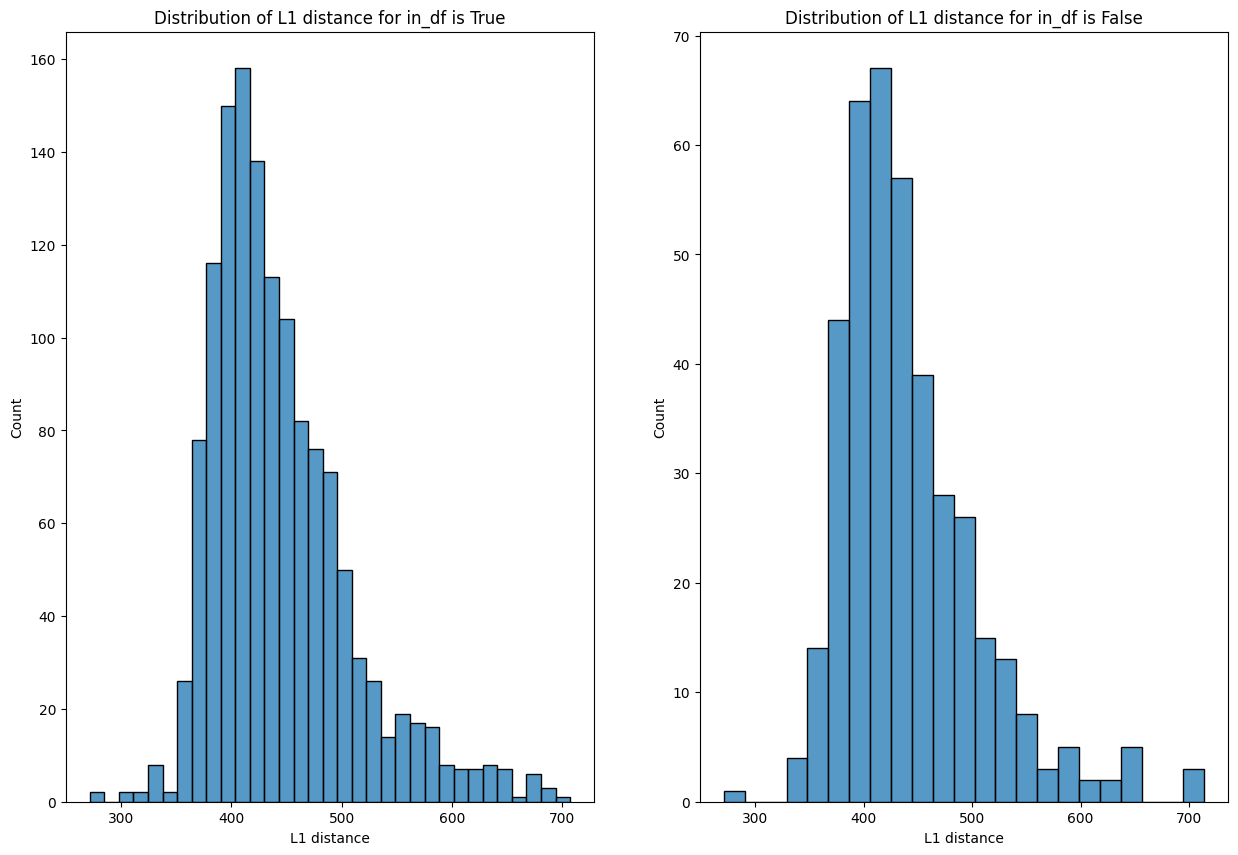

In [17]:
# compute the everage y_gt of df where in_dfnl is True and False
print("Average height for no Depth Loss model")
print(f"Predicted: {df[gt['in_df'] == True]['y_gt'].mean()}")
print(f"Missed! {df[gt['in_df'] == False]['y_gt'].mean()}")


fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# plot the disribution of l1_distance for in_df is True and False
sns.histplot(data=df[gt['in_df'] == True], x='y_gt', ax=axes[0])
sns.histplot(data=df[gt['in_df'] == False], x='y_gt', ax=axes[1])
# add title and labels
axes[0].set_title('Distribution of L1 distance for in_df is True')
axes[0].set_xlabel('L1 distance')
axes[0].set_ylabel('Count')
axes[1].set_title('Distribution of L1 distance for in_df is False')
axes[1].set_xlabel('L1 distance')
axes[1].set_ylabel('Count')




Text(0, 0.5, 'density')

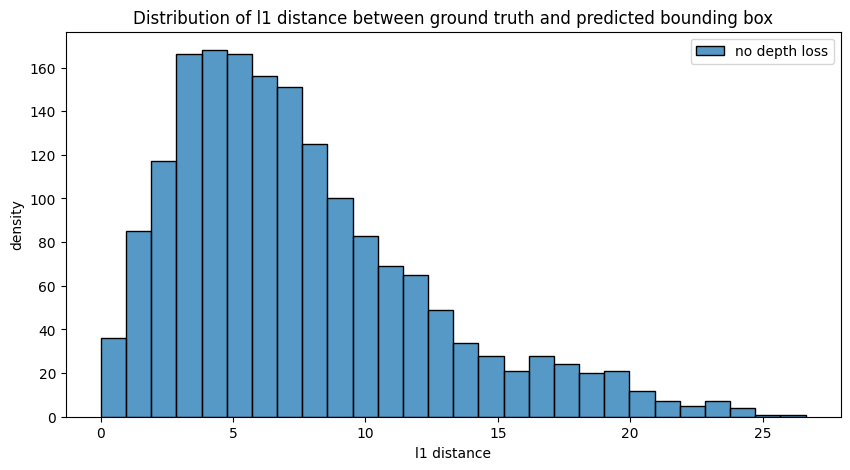

In [18]:
# plot the distribution of l1 distance using seaborn on the no depth loss model and the depth loss model
plt.figure(figsize=(10, 5))
sns.histplot(df['l1_distance'], label='no depth loss')
plt.legend()
plt.title('Distribution of l1 distance between ground truth and predicted bounding box')
plt.xlabel('l1 distance')
plt.ylabel('density')

## Visualize the missed polebases in the val set

## Density effect on the model
Let's see if the model struggles with high pole density


In [19]:
# Create a new dataframe with the basename of the image and the number of elemebts from gt_data
# that are in the dataframe
rows = []

for index,row in gt.iterrows():
    rows.append({'basename': row['basename'], 'gt_count': len(gt[gt.basename == row['basename']])})
    
gt_context = pd.DataFrame(rows)
# drop duplicate rows
gt_context.drop_duplicates(inplace=True)

# add for each row the number of elements found in df
gt_context['tp_count'] = gt_context.apply(lambda row: len(df[df.basename == row['basename']]), axis=1)
gt_context['fn_count'] = gt_context.apply(lambda row: row['gt_count'] - row['tp_count'], axis=1)
gt_context['missed_ratio'] = gt_context.apply(lambda row: row['fn_count'] / row['gt_count'], axis=1)

<AxesSubplot:xlabel='gt_count', ylabel='Count'>

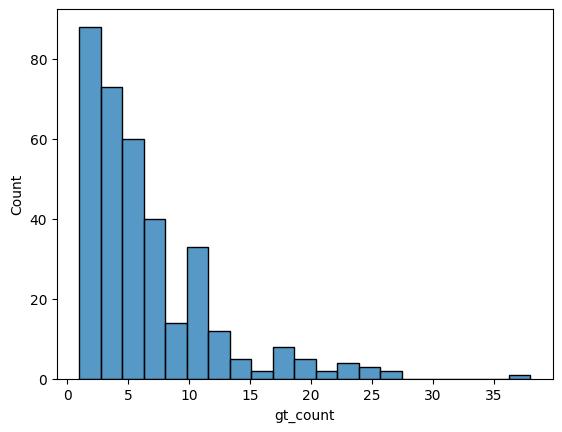

In [20]:
sns.histplot(gt_context['gt_count'])

<AxesSubplot:xlabel='gt_count', ylabel='fn_count'>

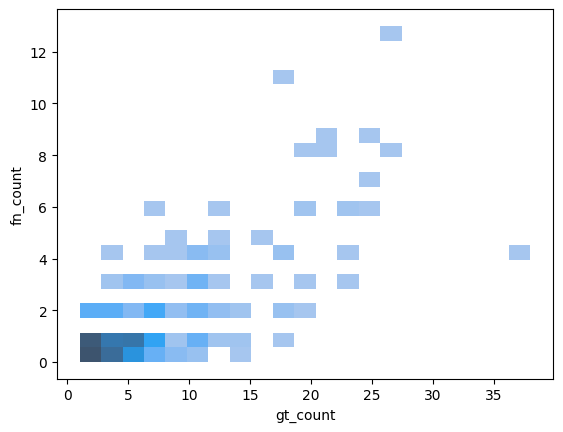

In [21]:
# Study the relationship betweeen the number of elements in gt_data vs the effectivness of the model
sns.histplot(x='gt_count', y='fn_count', data=gt_context)

In [22]:
# build a new df based on gt and get the avg y_gt for each basename
rows = []
for index, row in gt.iterrows():
    rows.append({'basename': row['basename'], 'y_gt': row['y_gt']})

gt_avg = pd.DataFrame(rows)
gt_avg.drop_duplicates(inplace=True)
gt_avg['y_gt_avg'] = gt_avg.apply(lambda row: gt_avg[gt_avg.basename == row['basename']]['y_gt'].median(), axis=1)
gt_avg.drop(columns=['y_gt'], inplace=True)
gt_avg.drop_duplicates(inplace=True)


<AxesSubplot:xlabel='y_gt_avg', ylabel='Count'>

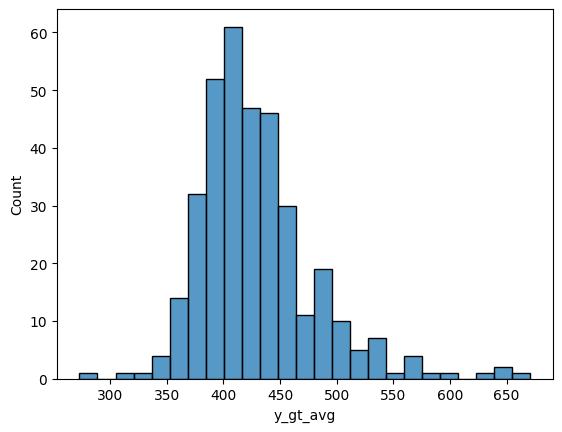

In [23]:
# histogram of the avg y_gt
sns.histplot(gt_avg['y_gt_avg'])

<AxesSubplot:xlabel='y_gt_avg', ylabel='Count'>

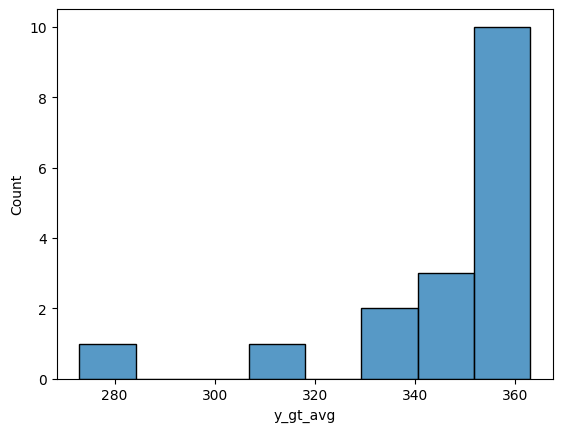

In [24]:
# plot 5% of the avg y_gt
sns.histplot(gt_avg[gt_avg.y_gt_avg < gt_avg.quantile(0.05)['y_gt_avg']].y_gt_avg)

<AxesSubplot:xlabel='y_gt_avg', ylabel='Count'>

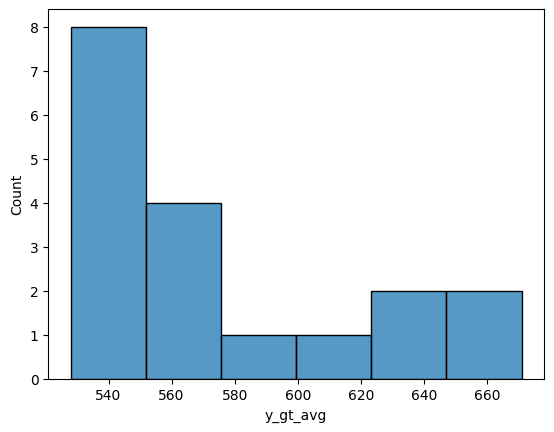

In [25]:
# plot 5% of the avg y_gt
sns.histplot(gt_avg[gt_avg.y_gt_avg > gt_avg.quantile(0.95)['y_gt_avg']].y_gt_avg)

In [34]:
gt_avg[gt_avg.y_gt_avg > gt_avg.quantile(0.90)['y_gt_avg']].info()
# Save dataframe to csv
gt_avg.to_csv('data/pole_avg_y_gt_top_90_perc.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 185 to 2197
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   basename  36 non-null     int64  
 1   y_gt_avg  36 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 864.0 bytes


In [51]:
gt_avg[gt_avg.y_gt_avg < gt_avg.quantile(0.15)['y_gt_avg']].info()
# Save dataframe to csv
gt_avg.to_csv('data/pole_avg_y_gt_bottom_10_perc.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 53 entries, 0 to 2194
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   basename  53 non-null     int64  
 1   y_gt_avg  53 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


In [57]:
gt_context[gt_context.gt_count >= gt_context.quantile(0.85)['gt_count']].info()
# Save dataframe to csv
gt_context.to_csv('data/pole_gt_density_top_15_perc.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, 2 to 2249
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   basename      54 non-null     int64  
 1   gt_count      54 non-null     int64  
 2   tp_count      54 non-null     int64  
 3   fn_count      54 non-null     int64  
 4   missed_ratio  54 non-null     float64
dtypes: float64(1), int64(4)
memory usage: 2.5 KB


In [58]:
gt_context[gt_context.gt_count <= gt_context.quantile(0.15)['gt_count']]
# Save dataframe to csv
gt_context.to_csv('data/pole_gt_density_bottom_15_perc.csv', index=False)